In [1]:
import torch
import os
import torch.nn as nn

model_type = 'pretrained'
out_target = 1


In [2]:

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        torch_model.record(out)
        out = self.bn1(out)
        out = self.relu(out)
        torch_model.record(out)
        out = self.conv2(out)
        torch_model.record(out)
        out = self.bn2(out)
        torch_model.record(out)
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        torch_model.record(out)

        out = self.relu(out)
        torch_model.record(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = conv3x3(3, self.inplanes)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.collecting = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
    
    def record(self, t):
        if self.collecting:
            self.gram_feats.append(t)
    
    def gram_feature_list(self,x):
        self.collecting = True
        self.gram_feats = []
        self.forward(x)
        self.collecting = False
        temp = self.gram_feats
        self.gram_feats = []
        return temp
    
    def get_min_max(self, data, power):
        mins = []
        maxs = []
        which_layer=1
        for i in range(0,len(data),128):
            batch = data[i:i+128].cuda()
            feat_list = self.gram_feature_list(batch)
            for L1,feat_L in enumerate(feat_list):
                if L1%which_layer==0:
                    L=L1//which_layer
                    if L==len(mins):
                        mins.append([None]*len(power))
                        maxs.append([None]*len(power))

                    for p,P in enumerate(power):
                        g_p = G_p(feat_L,P)

                        current_min = g_p.min(dim=0,keepdim=True)[0]
                        current_max = g_p.max(dim=0,keepdim=True)[0]

                        if mins[L][p] is None:
                            mins[L][p] = current_min
                            maxs[L][p] = current_max
                        else:
                            mins[L][p] = torch.min(current_min,mins[L][p])
                            maxs[L][p] = torch.max(current_max,maxs[L][p])
        
        return mins,maxs


    def get_min_max_real(self, data, power):
        mins = []
        maxs = []
        which_layer=1
        for i in range(0,len(data),128):
            batch = data[i:i+128].cuda()
            feat_list = self.gram_feature_list(batch)
            for L1,feat_L in enumerate(feat_list):
                if L1%which_layer==0:
                    L=L1//which_layer
                    if L==len(mins):
                        mins.append([None]*len(power))
                        maxs.append([None]*len(power))

                    for p,P in enumerate(power):
                        g_p = G_p_entire(feat_L,P)

                        current_max = g_p.max(dim=0,keepdim=True)[0]
                        current_min = g_p.min(dim=0,keepdim=True)[0]

                        if mins[L][p] is None:
                            mins[L][p] = current_min
                            maxs[L][p] = current_max
                        else:
                            mins[L][p] = torch.min(current_min,mins[L][p])
                            maxs[L][p] = torch.max(current_max,maxs[L][p])
        
        return mins,maxs

    def get_deviations(self,data,power,mins,maxs):
        deviations = []
        which_layer=1
        for i in range(0,len(data),128):            
            batch = data[i:i+128].cuda()
            feat_list = self.gram_feature_list(batch)
            batch_deviations = []
            for L1,feat_L in enumerate(feat_list):
                if L1%which_layer==0:
                    L=L1//which_layer
                    dev = 0
                    for p,P in enumerate(power):
                        g_p = G_p(feat_L,P)

                        dev +=  (F.relu(mins[L][p]-g_p)/torch.abs(mins[L][p]+10**-6)).sum(dim=1,keepdim=True)
                        dev +=  (F.relu(g_p-maxs[L][p])/torch.abs(maxs[L][p]+10**-6)).sum(dim=1,keepdim=True)
                    batch_deviations.append(dev.cpu().detach().numpy())
            batch_deviations = np.concatenate(batch_deviations,axis=1)
            deviations.append(batch_deviations)
        deviations = np.concatenate(deviations,axis=0)
        
        return deviations


def _resnet(arch, block, num_classes, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, num_classes, **kwargs)
    if pretrained:
        state_dict = torch.hub.load_state_dict_from_url(model_urls[arch],
                                            progress=progress)
        state_dict['fc.weight']=state_dict['fc.weight'].data[range(num_classes),:]
        state_dict['fc.bias']=state_dict['fc.bias'].data[range(num_classes)]
        model.load_state_dict(state_dict)
    return model

def resnet34(pretrained=1, num_classes=9,progress=True, **kwargs):
    if pretrained==1:
        pretrained=True
        print("*** Pre Trained : True")
    else: 
        pretrained=False
        print("*** Pre Trained : False")
    return _resnet('resnet34', BasicBlock, num_classes, [3, 4, 6, 3], pretrained, progress,
                **kwargs)
    # model = ResNet_128(BasicBlock, [3,4,6,3], num_classes=cfg['in_dataset']['num_classes'])

torch_model=resnet34(pretrained=0)
if model_type == 'scratch':
    tm=torch.load('./pre_trained/MNIST_new_scratch_out_'+str(out_target)+'/ckpt/checkpoint_epoch_200.pyth',map_location='cpu')
else:
    tm=torch.load('./pre_trained/MNIST_new_pretrained_out_'+str(out_target)+'/ckpt/checkpoint_epoch_40.pyth',map_location='cpu')
torch_model.load_state_dict(tm['model_state'])
torch_model.cuda()
torch_model.params = list(torch_model.parameters())
torch_model.eval()
print("Done")  

*** Pre Trained : False
Done


In [3]:
model_weights = []
conv_layers =[]
model_children=list(torch_model.children())

counter =0
for i in range(len(model_children)):
    if type(model_children[i])==nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i])==nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child)==nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)

print("Total Convolutional Layers : {}".format(counter))



Total Convolutional Layers : 33


In [9]:
for i in range(counter):    
    print(model_weights[i].data.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])


In [11]:
conv_layers[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [5]:
import cv2 as cv
import torchvision.transforms as transforms
import numpy as np
# read and visualize an image
img = cv.imread(f"./mnist_png/testing/0/3.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())


torch.Size([3, 28, 28])
torch.Size([1, 3, 28, 28])


In [6]:
# pass the image through all the layers
results = [conv_layers[0](img.cuda())]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

# make a copy of the `results`
outputs = results


In [25]:
outputs[0].shape

torch.Size([1, 64, 28, 28])

In [8]:
import matplotlib.pyplot as plt

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu().detach(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(os.path.join("feature_visualization",model_type,"layer_"+str(num_layer)+".png"))
    # plt.show()
    plt.close()


torch.Size([64, 28, 28])
Saving layer 0 feature maps...
torch.Size([64, 28, 28])
Saving layer 1 feature maps...
torch.Size([64, 28, 28])
Saving layer 2 feature maps...
torch.Size([64, 28, 28])
Saving layer 3 feature maps...
torch.Size([64, 28, 28])
Saving layer 4 feature maps...
torch.Size([64, 28, 28])
Saving layer 5 feature maps...
torch.Size([64, 28, 28])
Saving layer 6 feature maps...
torch.Size([128, 14, 14])
Saving layer 7 feature maps...
torch.Size([128, 14, 14])
Saving layer 8 feature maps...
torch.Size([128, 14, 14])
Saving layer 9 feature maps...
torch.Size([128, 14, 14])
Saving layer 10 feature maps...
torch.Size([128, 14, 14])
Saving layer 11 feature maps...
torch.Size([128, 14, 14])
Saving layer 12 feature maps...
torch.Size([128, 14, 14])
Saving layer 13 feature maps...
torch.Size([128, 14, 14])
Saving layer 14 feature maps...
torch.Size([256, 7, 7])
Saving layer 15 feature maps...
torch.Size([256, 7, 7])
Saving layer 16 feature maps...
torch.Size([256, 7, 7])
Saving laye

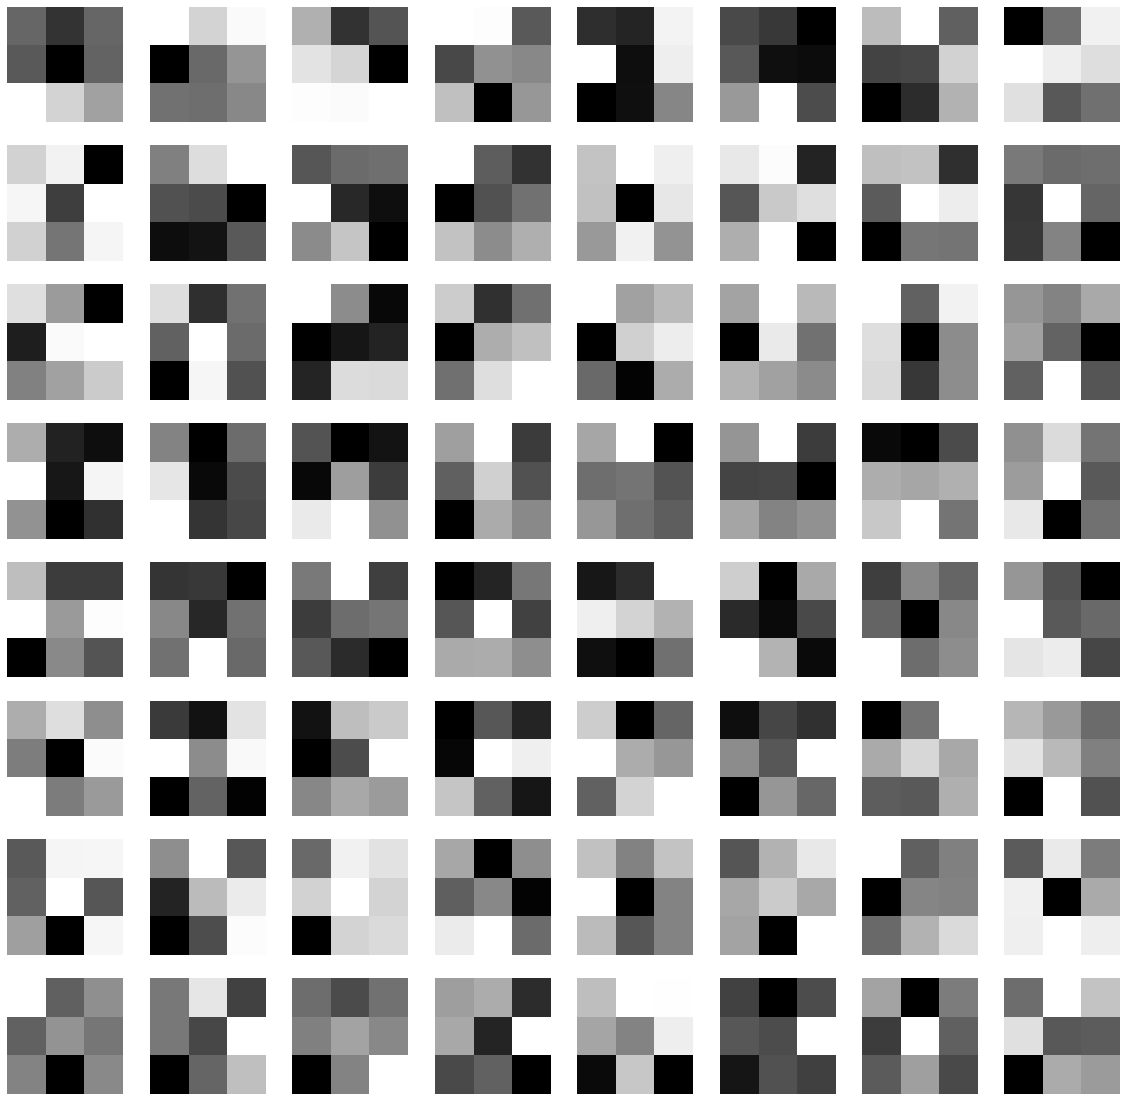

In [25]:
# plt.figure(figsize=(20,20))

# for i, filter in enumerate(model_weights[1]):
#     plt.subplot(8,8,i+1)
#     plt.imshow(filter[1,:,:].cpu().detach(), cmap='gray')
#     plt.axis('off')
# plt.show()